In [9]:
from winch import run_sim
from motors import (_775pro, minicim, cim, MotorSystem)
from utils import *
from matplotlib import pyplot as plt
import numpy


In [10]:
times = []
torques = []
velocities = []

def reporter(time, radius, position, **kwargs):
    if len(times) == 0:
        print ("time     r       c    theta      t")
    print ("%3.1f  %6.2f  %6.2f  %6.2f   %6.2f" % (
        time, meter_to_inch(radius), meter_to_inch(radius * 2 * 3.14), meter_to_inch(position), Nm_to_in_lbs(kwargs['winch_torque'])))
    times.append(time)
    torques.append(Nm_to_in_lbs(kwargs['winch_torque']))
    velocities.append(kwargs['velocity_rpm'])


run_sim(
    height_m=inch_to_meter(14), 
    mass_kg=lbs_to_kg(130), 
    winch_radius_m=inch_to_meter(.5), 
    rope_radius_m=inch_to_meter(0.), 
    motor_system=MotorSystem(minicim, motor_count=1, gearing_ratio=64),
    reporter=reporter
)

minicim, gearing ratio=64, 14.0 inches from ground, 130.0 lbs.
 max torque at 40A: 368.82 in-lbs
  radius =   2.84 in
 stall torque: 792.96 in-lbs
  radius =   6.10 in
r=0.0127 freesp= 10.14 F=578.48 L=  1.12 stallt= 89.60
xx:  9.44923681847627
initial radius=  0.50 in
time     r       c    theta      t
0.0    0.50    3.14    0.47    65.02
0.1    0.50    3.14    0.93    65.02
0.2    0.50    3.14    1.40    65.02
0.3    0.50    3.14    1.86    65.02
0.4    0.50    3.14    2.33    65.02
0.5    0.50    3.14    2.79    65.02
0.6    0.50    3.14    3.26    65.02
0.7    0.50    3.14    3.73    65.02
0.8    0.50    3.14    4.19    65.02
0.9    0.50    3.14    4.66    65.02
1.0    0.50    3.14    5.12    65.02
1.1    0.50    3.14    5.59    65.02
1.2    0.50    3.14    6.05    65.02
1.3    0.50    3.14    6.52    65.02
1.4    0.50    3.14    6.98    65.02
1.5    0.50    3.14    7.45    65.02
1.6    0.50    3.14    7.92    65.02
1.7    0.50    3.14    8.38    65.02
1.8    0.50    3.14    8.85  

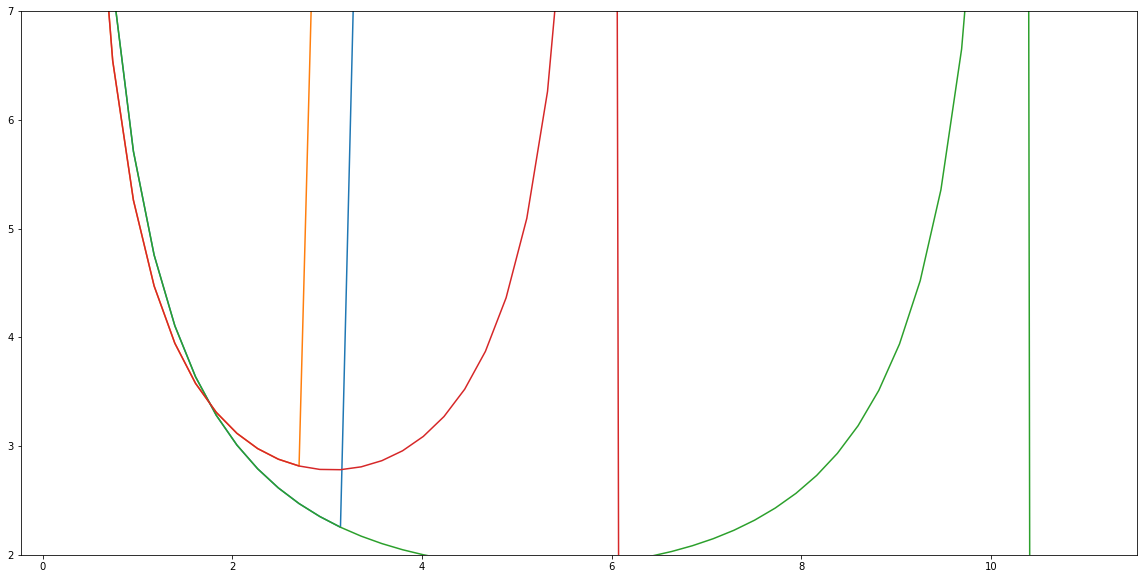

In [11]:
def time(r, L, mass_kg, motor, motor_count, gearing_ratio, show_40lim):
    winch_stall_torque = motor.stall_torque * motor_count * gearing_ratio
    torque_at_40 = motor.stall_at_40() * motor_count * gearing_ratio
    F = mass_kg * g
    freesp = 2 * numpy.pi * motor.free_speed / gearing_ratio / 60
    if torque_at_40 < F * r and show_40lim:
        return 10
    return L / (r * freesp * (1 - r * F / winch_stall_torque))

radii = numpy.linspace(inch_to_meter(.3), inch_to_meter(11))
m2in = numpy.vectorize(meter_to_inch)
radii_in = m2in(radii)
time_cim = numpy.vectorize(lambda r: time(r, inch_to_meter(43), lbs_to_kg(130), cim, 1, 64, True))
time_cim2 = numpy.vectorize(lambda r: time(r, inch_to_meter(43), lbs_to_kg(130), cim, 1, 64, False))

time_cim3 = numpy.vectorize(lambda r: time(r, inch_to_meter(43), lbs_to_kg(130), cim, 1, 154, True))
time_cim4 = numpy.vectorize(lambda r: time(r, inch_to_meter(43), lbs_to_kg(130), cim, 1, 154, False))
time_minicim = numpy.vectorize(lambda r: time(r, inch_to_meter(43), lbs_to_kg(130), minicim, 1, 64, True))
time_minicim2 = numpy.vectorize(lambda r: time(r, inch_to_meter(43), lbs_to_kg(130), minicim, 1, 64, False))
time_bag = numpy.vectorize(lambda r: time(r, inch_to_meter(43), lbs_to_kg(130), _775pro, 1, 104, True))
plt.figure(figsize=(20,10))
plt.ylim(2,7)

plt.plot(radii_in, time_cim(radii))
plt.plot(radii_in, time_minicim(radii))
plt.plot(radii_in, time_cim2(radii))
plt.plot(radii_in, time_minicim2(radii))


#plt.plot(radii_in, time_bag(radii))
plt.show()

In [24]:
def accelerate_sim(dt, mass_robot_kg, mass_winch_kg, winch_radius_m, rope_radius_m, motor_system):
    def _accel(v_rpm, r):
        motor_torque = motor_system.torque_at_speed(v_rpm)
        weight_torque = mass_robot_kg * g * r
        moment_of_inertia = 0.5 * mass_winch_kg * winch_radius_m ** 2
        a = (motor_torque - weight_torque) / moment_of_inertia
        return a
    ts = []
    alphas = []
    vels = []
    r = winch_radius_m
    t = 0
    v = rpm_to_radps(motor_system.free_speed) # angular velocity rad/s
    a = _accel(v, r) # angular acceleration rad/s^2
    while True:
        v = min(v + a * dt, rpm_to_radps(motor_system.free_speed))
        t += dt
        a = _accel(radps_to_rpm(v), r)
        ts.append(t)
        alphas.append(a)
        vels.append(v)
        
        if(abs(a) < 0.0001 or len(ts) > 10000):
            break
    
    return numpy.array(ts), numpy.array(alphas), numpy.array(vels)
    

In [25]:
ts, _as, vs = accelerate_sim(
    dt=0.00001, 
    mass_robot_kg=lbs_to_kg(130), 
    mass_winch_kg=lbs_to_kg(5), 
    winch_radius_m=inch_to_meter(.57),
    rope_radius_m=0,
    motor_system=MotorSystem(minicim, motor_count=1, gearing_ratio=64)
)

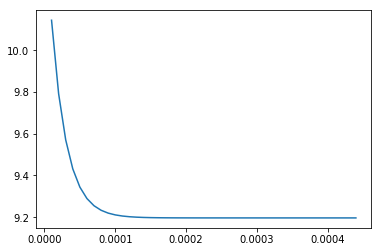

In [26]:
plt.plot(ts, vs)
plt.show()